This is the analysis for the ConvX (a Udacity Capstone Project). Before starting, be sure to follow the instructions in the README for the project on github (https://github.com/justiniann/ConvX).

This code was originally run on a personal desktop computer. The specs were...

CPU: Intel i5 6600K, 
GPU: Nvidia 1060 GTX, 
RAM: 16GB

I highly recommend that anyone attempting to run this code on the full dataset use hardware that is comparable or better.

First, we need to load our base model. We will also define a few variables that we will need later.

In [8]:
import os
import random
from keras.applications import ResNet50
from keras.layers import Dropout, GlobalAveragePooling2D, Dense
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, fbeta_score, confusion_matrix
import matplotlib.pyplot as plt
from convx_utils import *

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(512, 512, 3))
target_image_size = (512, 512)
batch_size = 32
transfer_learning_epochs = 1000
fine_tuning_epochs = 5
fine_tuning_layers_to_train = 10

We'll also define some paths that we will need later for saving various results as we run through our analysis

In [2]:
# The following are directories used for reading/saving data
RES_PATH = "..{0}..{0}resources{0}".format(os.path.sep)
IMG_PATH = "..{0}..{0}images{0}".format(os.path.sep)
BOTTLENECK_PATH = "..{0}..{0}bottleneck{0}".format(os.path.sep)
SAVE_PATH = "..{0}..{0}saved_models{0}".format(os.path.sep)
TRAIN_PATH = os.path.join(IMG_PATH, "train")
VAL_PATH = os.path.join(IMG_PATH, "validation")
TEST_PATH = os.path.join(IMG_PATH, "test")

model_name = "convx_model"  # The directory all data will be saved in will be named whatever this value is.
models_save_directory = os.path.join(SAVE_PATH, model_name)
build_dir_path(models_save_directory)  # build the directory structure we need for saving results

We haven't included the top layer because we are going to build and train the top layer ourselves. This is known as transfer learning, and it is the first major step in training our model.

Before starting that, however, we need to get a few variables we are going to need durring processing

In [3]:
def count_files(root_dir):
    return sum([len(files) for r, d, files in os.walk(root_dir)])

def get_iterations_per_epoch(total_images, batch_size):
    return np.ceil(total_images / batch_size)

healthy_train_images = count_files(os.path.join(TRAIN_PATH, "healthy"))
unhealthy_train_images = count_files(os.path.join(TRAIN_PATH, "unhealthy"))
healthy_validation_images = count_files(os.path.join(VAL_PATH, "healthy"))
unhealthy_validation_images = count_files(os.path.join(VAL_PATH, "unhealthy"))

num_training_steps = get_iterations_per_epoch((healthy_train_images + unhealthy_train_images), batch_size)
num_validation_steps = get_iterations_per_epoch((healthy_validation_images + unhealthy_validation_images), batch_size)

data_generator = ImageDataGenerator(
    rescale=1. / 255
)

For efficiency, we are going to get and save the bottleneck features for this model before we start with the transfer learning. By obtaining and saving these once, we can avoid having to run every image through the entire network durring every epoch. 

In [4]:
bottleneck_file_path = os.path.join(BOTTLENECK_PATH, model_name)
train_bottleneck_file = os.path.join(bottleneck_file_path, "train.npy")
validation_bottleneck_file = os.path.join(bottleneck_file_path, "validation.npy")
    
# Extract bottleneck features if they have not been already
if not os.path.exists(bottleneck_file_path):
    train_generator = data_generator.flow_from_directory(
        TRAIN_PATH,
        target_size=target_image_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )
    
    bottleneck_features_train = base_model.predict_generator(train_generator, num_training_steps)
    build_dir_path(bottleneck_file_path)
    np.save(open(train_bottleneck_file, 'wb'), bottleneck_features_train)
    
    validation_path_generator = data_generator.flow_from_directory(
        VAL_PATH,
        target_size=target_image_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )
    
    bottleneck_features_validation = base_model.predict_generator(validation_path_generator, num_validation_steps)
    np.save(open(validation_bottleneck_file, 'wb'), bottleneck_features_validation)

With the bottleneck features established, we can start transfer learning.

In [5]:
def build_fully_connected_top_layer(connecting_shape, dropout=True):
    top_layers = Sequential()
    top_layers.add(GlobalAveragePooling2D(input_shape=connecting_shape))
    top_layers.add(Dense(512, activation='relu'))
    if dropout:
        top_layers.add(Dropout(0.2))
    top_layers.add(Dense(2, activation='softmax'))
    return top_layers

def compile_model(model):
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

# load training data
train_data = np.load(open(train_bottleneck_file, 'rb'))
train_labels = to_categorical(np.array(([0] * healthy_train_images) + ([1] * unhealthy_train_images)),
                              num_classes=2)
# load validation data
validation_data = np.load(open(validation_bottleneck_file, 'rb'))
validation_labels = to_categorical(np.array([0] * healthy_validation_images + [1] * unhealthy_validation_images),
                                   num_classes=2)

top_layer = build_fully_connected_top_layer(train_data.shape[1:])

compile_model(top_layer)

transfer_history = top_layer.fit(train_data, train_labels,
                                  epochs=transfer_learning_epochs,
                                  batch_size=batch_size,
                                  validation_data=(validation_data, validation_labels),
                                  shuffle=True,
                                  verbose=1)

top_layers_weights_path = os.path.join(models_save_directory, "transfer_learning_weights.h5")
top_layer.save_weights(top_layers_weights_path)

Train on 80725 samples, validate on 8970 samples
Epoch 1/1000
80725/80725 [==============================] - 13s - loss: 7.4022 - acc: 0.5380 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 2/1000
80725/80725 [==============================] - 12s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 3/1000
80725/80725 [==============================] - 12s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 4/1000
80725/80725 [==============================] - 12s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 5/1000
80725/80725 [==============================] - 12s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 6/1000
80725/80725 [==============================] - 12s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 7/1000
80725/80725 [==============================] - 12s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 8/1000
80725/80725 [===============

80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 64/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 65/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 66/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 67/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 68/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 69/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 70/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - v

80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 126/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 127/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 128/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 129/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 130/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 131/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 132/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5

80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 188/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 189/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 190/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 191/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 192/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 193/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 194/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5

80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 250/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 251/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 252/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 253/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 254/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 255/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 256/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5

80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 312/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 313/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 314/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 315/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 316/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 317/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 318/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5

80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 374/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 375/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 376/1000
80725/80725 [==============================] - 12s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 377/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 378/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 379/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 380/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5

80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 436/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 437/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 438/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 439/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 440/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 441/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 442/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5

80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 498/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 499/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 500/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 501/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 502/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 503/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 504/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5

80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 560/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 561/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 562/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 563/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 564/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 565/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 566/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5

80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 622/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 623/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 624/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 625/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 626/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 627/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 628/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5

80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 684/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 685/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 686/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 687/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 688/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 689/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 690/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5

80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 746/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 747/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 748/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 749/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 750/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 751/1000
80725/80725 [==============================] - 12s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 752/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5

80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 808/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 809/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 810/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 811/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 812/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 813/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 814/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5

80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 870/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 871/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 872/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 873/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 874/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 875/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 876/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5

80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 932/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 933/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 934/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 935/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 936/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 937/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 938/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5

80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 994/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 995/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 996/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 997/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 998/1000
80725/80725 [==============================] - 12s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 999/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.5382 - val_loss: 7.4790 - val_acc: 0.5334
Epoch 1000/1000
80725/80725 [==============================] - 11s - loss: 7.4030 - acc: 0.

Transfer learning has been completed and the results have been saved! We can now combine the base model with our newly trained top layer and analyze the results.

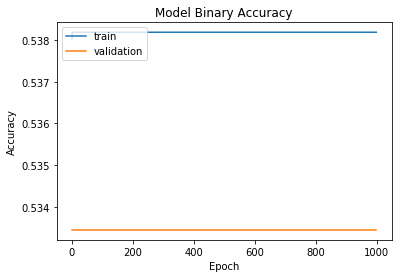

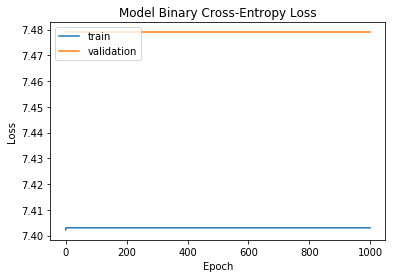

In [6]:
def display_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Binary Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Binary Cross-Entropy Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
display_history(transfer_history)

We can further improve our results by finetuning the model. Using the transfer learning model that we have already trained, we can 'unfreeze' a few of the layers from the base model. This will allow them to be trained, giving us an even better fit on the data. 

In [9]:
top_layer = build_fully_connected_top_layer(base_model.output_shape[1:], dropout=False)
top_layer.load_weights(top_layers_weights_path)
convx_model = Model(inputs=base_model.input, outputs=top_layer(base_model.output))

for layer in convx_model.layers[:len(convx_model.layers) - fine_tuning_layers_to_train]:
    layer.trainable = False

compile_model(convx_model)

train_generator = data_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=target_image_size,
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
    VAL_PATH,
    target_size=target_image_size,
    batch_size=batch_size,
    class_mode='categorical')

fine_tune_history = convx_model.fit_generator(
    train_generator,
    steps_per_epoch=num_training_steps,
    epochs=fine_tuning_epochs,
    validation_data=validation_generator,
    validation_steps=num_validation_steps,
    verbose=1
)

convx_model.save_weights(os.path.join(models_save_directory, "best_model_weights.h5"))

with open(os.path.join(models_save_directory, "best_model.json".format(model_name)), "w") as json_file:
    json_file.write(convx_model.to_json())

Found 80725 images belonging to 2 classes.
Found 8970 images belonging to 2 classes.
Epoch 1/5
2523/2523 [==============================] - 3610s - loss: 0.6212 - acc: 0.6646 - val_loss: 0.6117 - val_acc: 0.6775
Epoch 2/5
2523/2523 [==============================] - 3590s - loss: 0.5999 - acc: 0.6850 - val_loss: 0.6190 - val_acc: 0.6734
Epoch 3/5
2523/2523 [==============================] - 3590s - loss: 0.5906 - acc: 0.6933 - val_loss: 0.6300 - val_acc: 0.6601
Epoch 4/5
2523/2523 [==============================] - 3611s - loss: 0.5809 - acc: 0.6997 - val_loss: 0.5986 - val_acc: 0.6890
Epoch 5/5
2523/2523 [==============================] - 3976s - loss: 0.5703 - acc: 0.7098 - val_loss: 0.6109 - val_acc: 0.6805


Once again, we will plot the history of our training.

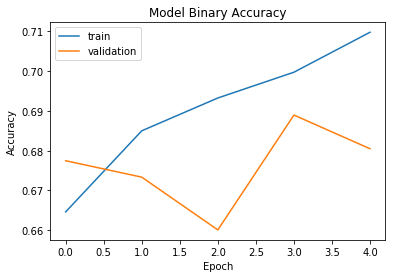

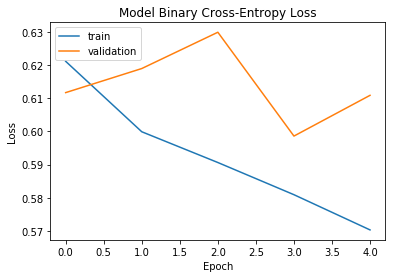

In [10]:
display_history(fine_tune_history)

Our model has now been fine tuned and the training process is complete! Lets evaluate the results. While we are also going to look at accuracy, our primary metric of evaluation is going to be f-beta, with a beta score of three. With this, we will get to see which models fit the data well while giving more weight to good recall. 

And now, the evaluation.

In [11]:
convx_model = None
with open(os.path.join(models_save_directory, "best_model.json"), 'r') as model_file:
    convx_model = model_from_json(model_file.read())
    
convx_model.load_weights(os.path.join(models_save_directory, "best_model_weights.h5"))
compile_model(convx_model)

healthy_test_images = count_files(os.path.join(TEST_PATH, "healthy"))
unhealthy_test_images = count_files(os.path.join(TEST_PATH, "unhealthy"))
test_iteration_count = get_iterations_per_epoch((healthy_test_images + unhealthy_test_images), batch_size)

# load test data
test_labels = np.array(([0] * healthy_test_images) + ([1] * unhealthy_test_images))
formatted_test_labels = to_categorical(test_labels, num_classes=2)

test_generator = data_generator.flow_from_directory(
    TEST_PATH,
    target_size=target_image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
)

raw_predictions = convx_model.predict_generator(test_generator, test_iteration_count, verbose=1)
predicted_labels = np.argmax(raw_predictions, axis=1)

accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy: {}".format(accuracy))

f3_score = fbeta_score(test_labels, predicted_labels, 3)
print("F3 Score: {}".format(f3_score))

conf_matrix = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix: \n{}".format(conf_matrix))

Found 22424 images belonging to 2 classes.
701/701 [==============================] - 992s   
Accuracy: 0.6820816981805209
F3 Score: 0.7061623655191608
Confusion Matrix: 
[[7937 4193]
 [2936 7358]]
